In [1]:
# Second experiment implements data replication across 2 nodes
# We then measure the average ms it takes to complete a request

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import scipy

import statistics


In [2]:
# Load the files in.
n_nodes = [4, 8, 16, 32]

def get_jobs(folderPath):
    jobs = []
    c = 0
    for file in os.listdir(folderPath):
        # Check if it is a benchmark log
        if file.startswith('benchmark') and file.endswith(".log"):
            c += 1
            fn = os.path.join(folderPath, file)
            with open(fn) as file:
                ls = file.readlines()
                # ls[1:] because the first line 
                jobs.extend([x.strip().split(']')[1].split(' ') for x in ls[1:]])
                
    print(f'Read {c} files for a total of {len(jobs)} jobs in {folderPath}')
    jobs = np.array(jobs, dtype=np.float32)
    jobs[:, 0] = jobs[:, 0] * 1000
    return jobs

def get_search_type(type):
    res = {}
    for n_node in n_nodes:
        res[n_node] = get_jobs(f'./results/{type}/results-{n_node}/')
    return res

linear_jobs = get_search_type('linear')
finger_jobs = get_search_type('finger')
linear_jobs_replicated = get_search_type('linear-replicated')
finger_jobs_replicated = get_search_type('finger-replicated')

Read 5 files for a total of 50000 jobs in ./results/linear/results-4/
Read 5 files for a total of 50000 jobs in ./results/linear/results-8/
Read 5 files for a total of 50000 jobs in ./results/linear/results-16/
Read 5 files for a total of 50000 jobs in ./results/linear/results-32/
Read 5 files for a total of 50000 jobs in ./results/finger/results-4/
Read 5 files for a total of 50000 jobs in ./results/finger/results-8/
Read 5 files for a total of 50000 jobs in ./results/finger/results-16/
Read 5 files for a total of 50000 jobs in ./results/finger/results-32/
Read 5 files for a total of 50000 jobs in ./results/linear-replicated/results-4/
Read 5 files for a total of 50000 jobs in ./results/linear-replicated/results-8/
Read 5 files for a total of 50000 jobs in ./results/linear-replicated/results-16/
Read 5 files for a total of 50000 jobs in ./results/linear-replicated/results-32/
Read 5 files for a total of 50000 jobs in ./results/finger-replicated/results-4/
Read 5 files for a total of 5

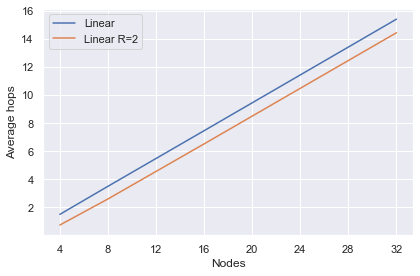

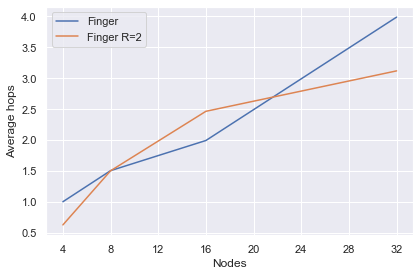

In [3]:
# Just do averages
def compare_average_hops(d1, d2, d1label, d2label):
    d1_mean = np.array([[key, statistics.mean(d1[key][:, 1])] for key in d1])
    d2_mean = np.array([[key, statistics.mean(d2[key][:, 1])] for key in d2])

    sns.set_theme()
    plt.xlabel('Nodes')
    plt.ylabel('Average hops')
    plt.xticks(np.arange(0, 33, 4))
    log = 0.5 * np.log2([4, 8, 16, 32])

    sns.lineplot(x=d1_mean[:, 0], y=d1_mean[:, 1], label=d1label)
    sns.lineplot(x=d2_mean[:, 0], y=d2_mean[:, 1], label=d2label)
    plt.tight_layout()
    plt.savefig(f'./graphs/avg_hops_nodes_{d1label}_{d2label}.pdf')
    plt.show()
    plt.close()

compare_average_hops(linear_jobs, linear_jobs_replicated, 'Linear', 'Linear R=2')
compare_average_hops(finger_jobs, finger_jobs_replicated, 'Finger', 'Finger R=2')

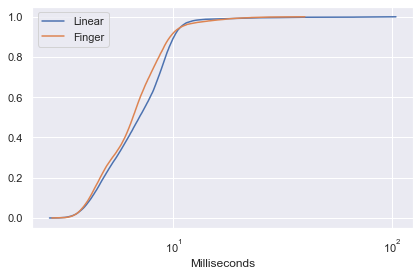

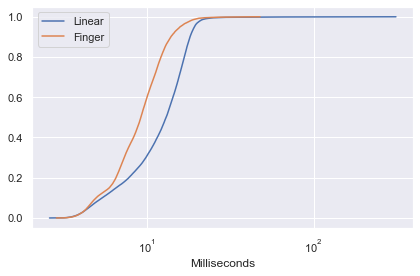

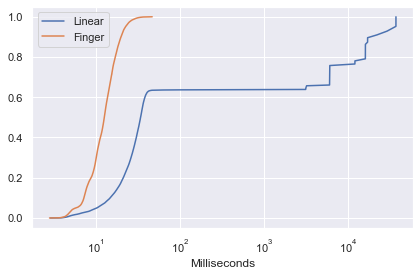

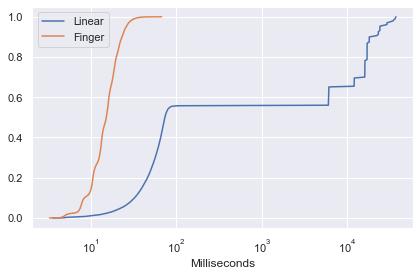

In [6]:
# CDFs for running time
for n_nodes in [4, 8, 16, 32]:
    lin = linear_jobs_replicated[n_nodes][:, 0]
    lin.sort()

    dx_lin = 1 / len(lin)
    lin_norm = lin / (dx_lin * lin).sum()
    CY_lin = np.cumsum(lin_norm * dx_lin)

    finger = finger_jobs_replicated[n_nodes][:, 0]
    finger.sort()

    dx_finger = 1 / len(finger)
    finger_norm = finger / (dx_finger * finger).sum()
    CY_finger = np.cumsum(finger_norm * dx_finger)

    sns.lineplot(x=lin, y=CY_lin, label='Linear')
    sns.lineplot(x=finger, y=CY_finger, label='Finger')
    plt.xscale('log')
    plt.xlabel('Milliseconds')
    plt.tight_layout()
    plt.savefig(f'./graphs/cdf_runtime_{n_nodes}_nodes.pdf')
    plt.show()
    plt.close()
